In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
from scipy.stats import entropy
import numpy as np
# import matplotlib.ticker as ticker
import networkx as nx
from networkx.algorithms.community import girvan_newman
import geopandas as gpd
# import contextily as ctx

In [282]:
books = pd.read_csv('../data/SCoData_books_v1.2_2022_01.csv', encoding='utf-8', dtype={'year': 'Int32'})
members = pd.read_csv('../data/SCoData_members_v1.2_2022_01.csv', encoding='utf-8')
events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')

C:\Users\dittm\AppData\Local\Temp\ipykernel_18820\1388952493.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')


## Authors in books

In [283]:
# Filter books of format 'Book', select relevant columns, and drop rows with any missing values.
# Then, split authors listed together with ';' into separate list elements.
book_authors = (
    books[(books['format'] == 'Book')] #& (books['year'] <= 1941)]  # Select rows where the format is 'Book' and the year is <= 1941.
    [['author']]  # Choose only the relevant columns.
    .dropna()  # Drop rows with any missing values in these columns.
    #.assign(author=lambda df: df['author'].str.split(';'))  # Split the 'author' string on each semicolon into a list of authors.
)

# book_authors.sample(10)

# Explode the 'author' column to create a new row for each author per book.
#exploded_authors = book_authors.explode('author')

# Remove duplicate entries to ensure all authors are unique across the dataset.
# Here we consider only the 'author' column for uniqueness.
unique_authors = book_authors.drop_duplicates(subset=['author'])

# Display a sample of the resulting DataFrame to verify the result.
unique_authors.sample(10)
unique_authors.shape


(1995, 1)

In [284]:
unique_authors.loc[unique_authors['author'] == 'Hemingway, Ernest']

,author
2140,"Hemingway, Ernest"


## Members

In [285]:
member_filtered = members[['sort_name']].dropna()
member_filtered.shape

(5235, 1)

In [286]:
member_filtered.sample(3)

,sort_name
181,"Baillon, Mme O."
4854,Van den Broek d'Obrenan
823,Cecile Dunbach


In [287]:
unique_members = member_filtered.drop_duplicates(subset=['sort_name'])
unique_members.shape

(4804, 1)

## Intersection: authors and members

In [288]:
unique_members.rename(columns={'sort_name': 'member'}, inplace=True)

merged_df = pd.merge(unique_members, unique_authors, how='outer', left_on='member', right_on='author')

merged_df.shape

C:\Users\dittm\AppData\Local\Temp\ipykernel_18820\3055481929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_members.rename(columns={'sort_name': 'member'}, inplace=True)


(6715, 2)

In [289]:
member_is_author = merged_df.dropna().reset_index(drop=True)
member_is_author = member_is_author[['member']]  # Keep the 'member' column as it now represents both member and author
member_is_author.columns = ['name']  # Rename the column

member_is_author.shape

(84, 1)

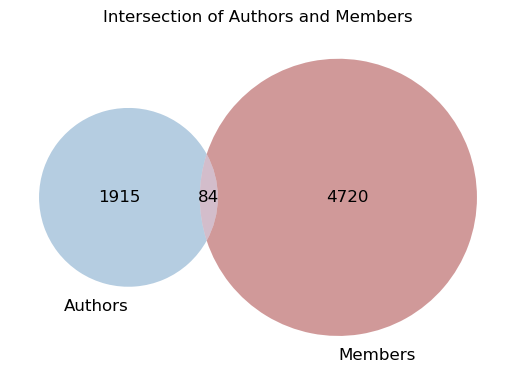

In [290]:
# Extract unique authors and members
unique_authors = set(books['author'])
unique_members = set(members['sort_name'])

# Calculate the intersection
intersection = len(unique_authors.intersection(unique_members))

# Create the Venn diagram for authors with customized colors
venn = venn2(subsets=(len(unique_authors) - intersection, len(unique_members) - intersection, intersection),
             set_labels=('Authors', 'Members'),
             set_colors=('steelblue', 'darkred'))

# Optionally, you can customize more properties, such as the transparency (alpha)
for subset in venn.subset_labels:
    if subset:  # If the subset is not None
        subset.set_fontsize(12)

plt.title('Intersection of Authors and Members')
plt.show()

In [291]:
# Calculate the percentages
percent_intersection_authors = (intersection / len(unique_authors)) * 100
percent_intersection_members = (intersection / len(unique_members)) * 100

print(f'Percent of the intersection relative to authors: {percent_intersection_authors:.2f}%')
print(f'Percent of the intersection relative to members: {percent_intersection_members:.2f}%')

Percent of the intersection relative to authors: 4.20%
Percent of the intersection relative to members: 1.75%


## Borrow comparisons

books by member

In [292]:
books_by_member_events = events[events['item_authors'].isin(member_is_author['name'])]

borrow: books by member

In [293]:
borrow_by_author = books_by_member_events[books_by_member_events['event_type'] == 'Borrow']
borrow_by_author.shape

(1539, 28)

In [294]:
borrow_by_author['event_type'].unique()

array(['Borrow'], dtype=object)

borrow: books by author, member is author

In [295]:
borrow_by_author = borrow_by_author[borrow_by_author['member_sort_names'].isin(member_is_author['name'])]
borrow_by_author.event_type.unique()
borrow_by_author.shape

(73, 28)

In [296]:
borrow_by_author.member_sort_names.unique()

array(['Joyce, James', 'Hemingway, Ernest', 'Beach, Sylvia',
       'Wilson, Romer', 'Aragon, Louis', 'Stein, Gertrude',
       'Rodker, John', 'Mansfield, Katherine', 'Solano, Solita',
       'de Lanux, Pierre', 'Wickham, Anna', 'Le Gallienne, Richard',
       'Gilbert, Stuart', 'Porter, Katherine Anne', 'Connolly, Cyril',
       'Gascoyne, David', 'Dennis, Mary Cable', 'Merrick, Leonard',
       'Rogers, Samuel', 'Ford, Ford Madox', 'Paul, Elliot'], dtype=object)

In [297]:
borrow_by_author.shape

(73, 28)

### books

In [298]:
books_event_borrow = events[events['event_type'] == 'Borrow']
books_event_borrow.shape

(21059, 28)

In [299]:
books_event_borrow_isAuthor = books_event_borrow[books_event_borrow['member_sort_names'].isin(member_is_author['name'])]
# books_event_borrow_isAuthor.event_type.unique()
books_event_borrow_isAuthor.shape

(877, 28)

In [300]:
books_event_borrow_isAuthor.member_sort_names.unique()

array(['Joyce, James', 'Hemingway, Ernest', 'Schlumberger, Jean',
       'Beach, Sylvia', 'Stein, Gertrude', 'Larbaud, Valery',
       'McAlmon, Robert', 'Wilson, Romer', 'Aragon, Louis',
       'Rodker, John', 'Wilder, Thornton', 'Pound, Ezra',
       'Mansfield, Katherine', 'Solano, Solita', 'de Lanux, Pierre',
       'Tree, Iris', 'Wickham, Anna', 'Wilson, Margaret',
       'Le Gallienne, Richard', 'Gilbert, Stuart', 'Boyd, James',
       'Flandrau, Grace', 'Porter, Katherine Anne', 'Lewisohn, Ludwig',
       'Tate, Allen', 'Gascoyne, David', 'Connolly, Cyril',
       'Merrick, Leonard', 'Dennis, Mary Cable', 'Rogers, Samuel',
       'Guilloux, Louis', 'Gramont, Élisabeth de', 'Ford, Ford Madox',
       'Paul, Elliot', 'Michaux, Henri', 'Wright, Richard', 'Gide, André'],
      dtype=object)

In [301]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
user_book_matrix = borrow_by_author.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(user_book_matrix.tail(2))

item_title         A Companion Volume  A Farewell to Arms  A Good Woman  \
member_sort_names                                                         
Wilson, Romer                       0                   0             0   
de Lanux, Pierre                    2                   0             0   

item_title         A Hasty Bunch  A Mirror to France  A Modern Hero  \
member_sort_names                                                     
Wilson, Romer                  0                   0              0   
de Lanux, Pierre               1                   0              0   

item_title         A Portrait of the Artist as a Young Man  \
member_sort_names                                            
Wilson, Romer                                            1   
de Lanux, Pierre                                         0   

item_title         A. O. Barnabooth: His Diary  \
member_sort_names                                
Wilson, Romer                                0   
de Lanux, Pierr

In [302]:
books_event_borrow.head(2)

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,...,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image
2,Borrow,1922,1922-08-23,https://shakespeareandco.princeton.edu/members...,Mr. Rhys,"Rhys, Mr.",NaN,NaN,NaN,NaN,...,https://shakespeareandco.princeton.edu/books/c...,Typhoon,NaN,"Conrad, Joseph",1902.0,NaN,Lending Library Card,"Sylvia Beach, Rhys Lending Library Card, Box 4...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/67...
8,Borrow,1923,1923-11-07,https://shakespeareandco.princeton.edu/members...,Eyre de Lanux / Mrs. Pierre de Lanux,"de Lanux, Eyre",NaN,NaN,NaN,NaN,...,https://shakespeareandco.princeton.edu/books/w...,Night and Day,NaN,"Woolf, Virginia",1919.0,NaN,Lending Library Card,"Sylvia Beach, Eyre de Lanux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...


In [303]:
books_event_borrow.member_sort_names.unique()

array(['Rhys, Mr.', 'de Lanux, Eyre', 'Téry, Simone',
       'MacLeish, Ada;MacLeish, Archibald', 'de Alvear, Elvira',
       'Joyce, James', 'Peake, Catherine;Peake, Charles',
       'Mespoulet, Suzanne', 'Colens, Fernand', 'Rirachowsky, Fanny',
       'Bertrand-Fontaine, Thérèse', 'Sonnabend', 'Lafleur, Mlle',
       'Alexandre, M.', 'Gereblon', 'Bernheim, Antoinette', 'Mattos',
       'Nguyên Minh Truyet', 'Vincens', 'Gros', 'Claudius, Agnes',
       'Theves, Elizabeth', 'de Vigan, Monique', 'de Wendel, Hélène',
       'Wright, Ellen', 'Harvey, Dorothy', 'Hartmann, Françoise',
       'Gray, William', 'Pagan, Marquis', 'Oerthel, Maurice',
       'Syrett, Netta', 'Rolland, Madeleine', 'Wallace, Lillian',
       'Linossier, Raymonde', 'Michaelides, Mme L.', 'Violette, Mme G.',
       'Schereck, Mildred', 'Ottensooser, Colette', 'Killen, Alice M.',
       'Ottocar, Mlle', 'Philip, Terence', 'Raphaël, France Emma',
       'Wilson, Natalie', 'Vogein, Pierre', 'Murray, John',
       'Hemin

In [304]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
user_book_matrix_all = books_event_borrow_isAuthor.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(user_book_matrix_all.tail(2))

item_title         A Bookman's Daybook  A Companion Volume  \
member_sort_names                                            
Wright, Richard                      0                   0   
de Lanux, Pierre                     0                   2   

item_title         A Concise History of Ireland  \
member_sort_names                                 
Wright, Richard                               0   
de Lanux, Pierre                              0   

item_title         A Dark Lantern: A Story with a Prologue  \
member_sort_names                                            
Wright, Richard                                          0   
de Lanux, Pierre                                         0   

item_title         A Farewell to Arms  A Foregone Conclusion  A Gallery  \
member_sort_names                                                         
Wright, Richard                     0                      0          0   
de Lanux, Pierre                    0                      0          0 

In [305]:
# Sum the borrow counts across all users to get the total borrow count for each book
borrow_counts_all = user_book_matrix_all.sum(axis=0).reset_index()
borrow_counts_all.columns = ['book_title', 'borrow_count']

# Display the top 10 most borrowed books as a sanity check
print(borrow_counts_all.sort_values(by='borrow_count', ascending=False).head(15))

                                            book_title  borrow_count
378                      Saturday Review of Literature             9
733                                         transition             8
688                          Thomas De Quincey's Works             6
210                                       Hound & Horn             4
99                                               Broom             4
486                                           The Dial             4
307                                         New Masses             4
32             A Portrait of the Artist as a Young Man             4
639                   The Symposium: A Critical Review             3
676  The Works of Sterne: The Life and Opinions of ...             3
583                                   The New Republic             3
61                                        And Even Now             3
236                            Lady Chatterley's Lover             3
432               The Autobiograph

In [306]:
# Sum the borrow counts across all users to get the total borrow count for each book
borrow_counts = user_book_matrix.sum(axis=0).reset_index()
borrow_counts.columns = ['book_title', 'borrow_count']

# Display the top 10 most borrowed books as a sanity check
print(borrow_counts.sort_values(by='borrow_count', ascending=False).head(15))

                                           book_title  borrow_count
6             A Portrait of the Artist as a Young Man             4
0                                  A Companion Volume             3
35               The Autobiography of Alice B. Toklas             3
47                                        Three Lives             3
4                                  A Mirror to France             2
49  To Return to Yesterday: Reminiscences 1894 – 1914             2
8   Back to Montparnasse: Glimpses of Broadway in ...             2
28              Oscar Wilde: His Life and Confessions             2
11                             Death in the Afternoon             2
12                Distinguished Air: Grim Fairy Tales             2
46                              This Side of Paradise             2
31                                 Strait Is the Gate             2
37                                 The Counterfeiters             2
17                                Geography and 

In [307]:
# Create an empty graph
G = nx.Graph()

# Add nodes and edges based on the user-book matrix
for user1 in user_book_matrix.index:
    for user2 in user_book_matrix.index:
        if user1 != user2:
            # Calculate intersection of books borrowed by both users
            common_books = sum((user_book_matrix.loc[user1] > 0) & (user_book_matrix.loc[user2] > 0))
            if common_books > 0:
                G.add_edge(user1, user2, weight=common_books)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 14
Number of edges: 18


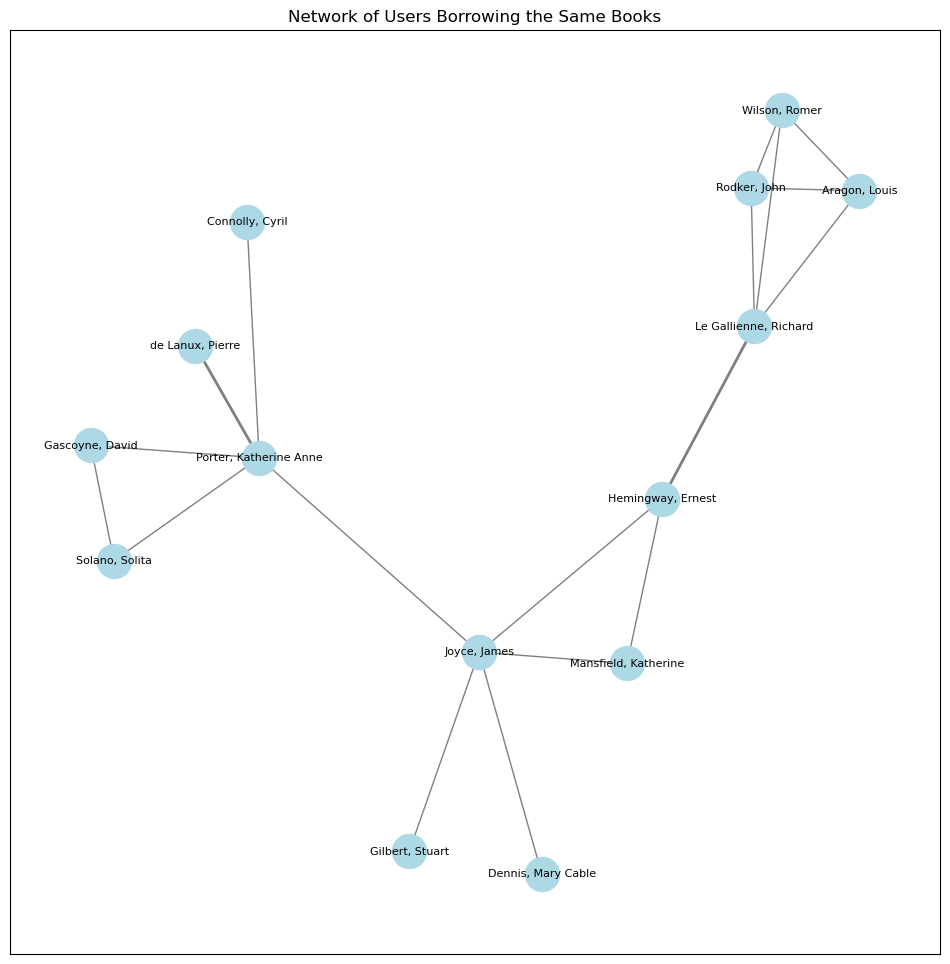

In [308]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

In [309]:
# Create subgraph of Hemingway's neighbors
hemingway_neighbors=nx.subgraph(G,list(nx.neighbors(G,'Hemingway, Ernest')))

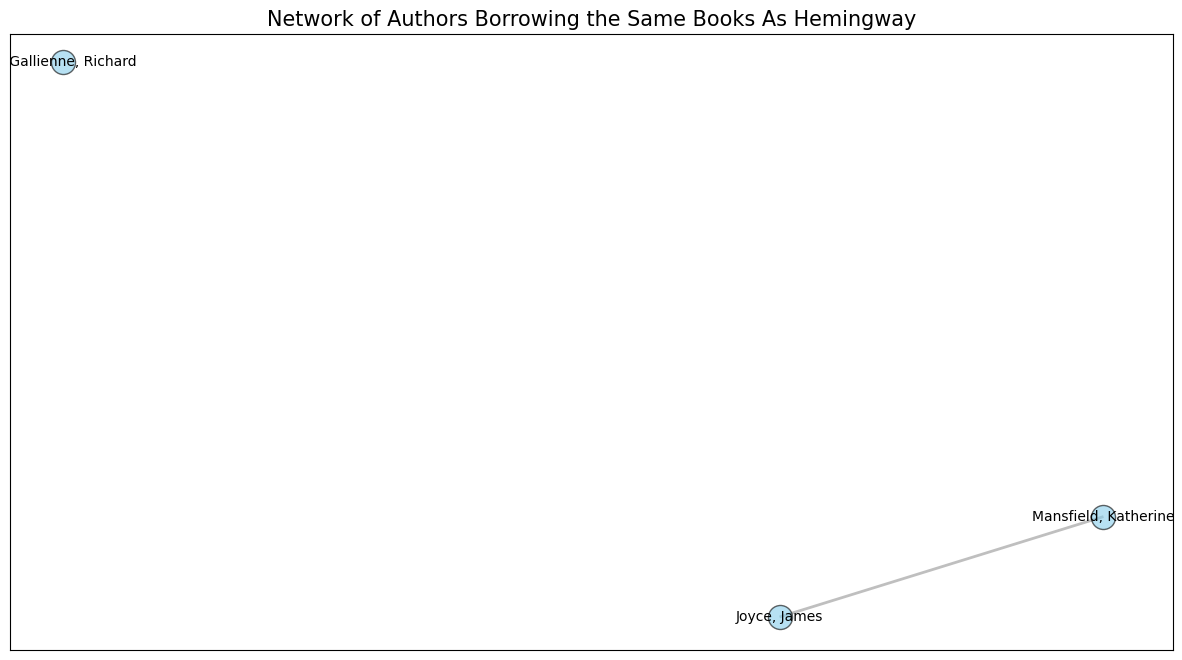

In [310]:
# Visualization
plt.figure(figsize=(15, 8))

# Using the Kamada-Kawai layout
pos = nx.spring_layout(hemingway_neighbors, weight=None, k=0.8)

# Drawing the nodes
nx.draw_networkx_nodes(hemingway_neighbors, pos, node_size=300, node_color='skyblue', alpha=0.6, edgecolors='black')

# Drawing the edges
nx.draw_networkx_edges(hemingway_neighbors, pos, width=2, alpha=0.5, edge_color='gray')

# Drawing the labels
nx.draw_networkx_labels(hemingway_neighbors, pos, font_size=10, font_color='black')

# Add a title
plt.title('Network of Authors Borrowing the Same Books As Hemingway', size=15)

# Show plot
plt.show()

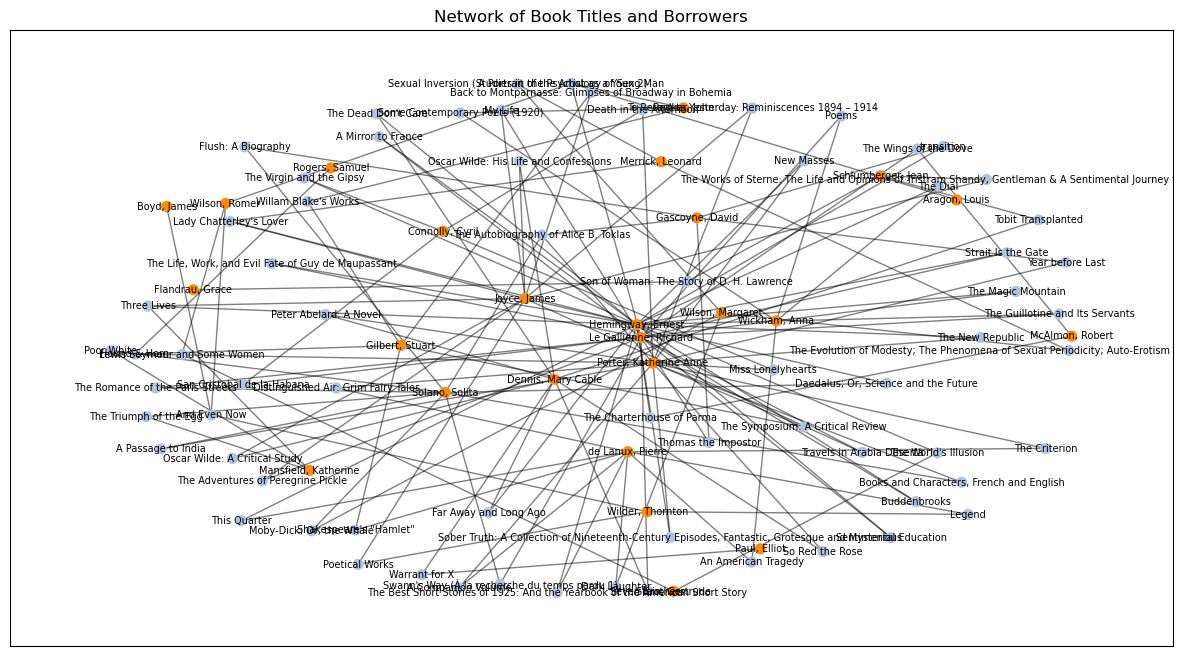

In [311]:
# Convert pivot table to edge list
edge_list = user_book_matrix_all.stack().reset_index()
edge_list.columns = ['member_sort_names', 'item_title', 'borrowed']
edge_list = edge_list[edge_list['borrowed'] > 0]

# Filter books that were only borrowed once overall
book_counts = edge_list['item_title'].value_counts()
books_multi_borrowed = book_counts[book_counts > 1].index
edge_list = edge_list[edge_list['item_title'].isin(books_multi_borrowed)]

# Create a graph from the edge list
G_T = nx.from_pandas_edgelist(edge_list, source='item_title', target='member_sort_names', create_using=nx.Graph())

# Visualization
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G_T, seed=42, k=0.9)  # Positions for all nodes
#0.3
#0.6

# Assign colors to nodes
node_colors = ['lightsteelblue' if node in edge_list['item_title'].unique() else 'darkorange' for node in G_T]

# Draw nodes and edges with the assigned colors
nx.draw_networkx_nodes(G_T, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G_T, pos, alpha=0.5)
nx.draw_networkx_labels(G_T, pos, font_size=7)

plt.title('Network of Book Titles and Borrowers')
plt.show()

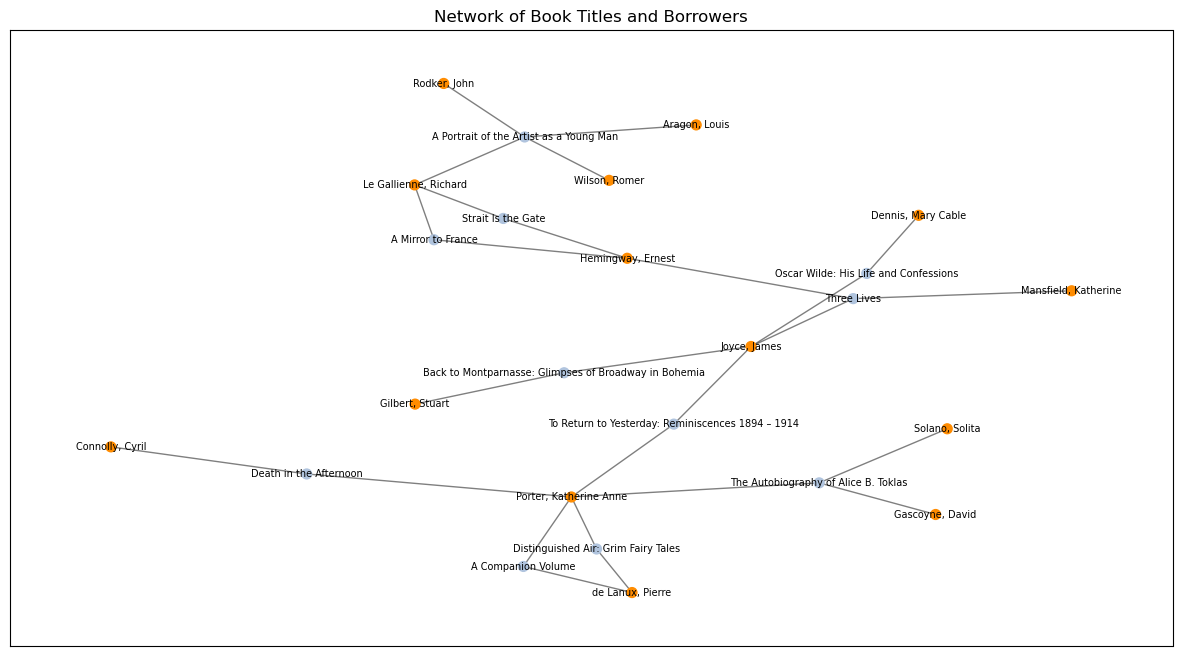

In [312]:
# Convert pivot table to edge list
edge_list = user_book_matrix.stack().reset_index()
edge_list.columns = ['member_sort_names', 'item_title', 'borrowed']
edge_list = edge_list[edge_list['borrowed'] > 0]

# Filter books that were only borrowed once overall
book_counts = edge_list['item_title'].value_counts()
books_multi_borrowed = book_counts[book_counts > 1].index
edge_list = edge_list[edge_list['item_title'].isin(books_multi_borrowed)]

# Create a graph from the edge list
L_M = nx.from_pandas_edgelist(edge_list, source='item_title', target='member_sort_names', create_using=nx.Graph())

# Visualization
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(L_M,  seed=42, k=0.2, iterations=25)  # Positions for all nodes
#0.3
#0.6

# Assign colors to nodes
node_colors = ['lightsteelblue' if node in edge_list['item_title'].unique() else 'darkorange' for node in L_M]

# Draw nodes and edges with the assigned colors
nx.draw_networkx_nodes(L_M, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(L_M, pos, alpha=0.5)
nx.draw_networkx_labels(L_M, pos, font_size=7)

plt.title('Network of Book Titles and Borrowers')
plt.show()